In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
!pip install geopandas
import geopandas as gpd
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('./drive/MyDrive/data/mf_geo_train.csv')
test = pd.read_csv('./drive/MyDrive/data/mf_geo_test.csv')

In [ ]:
train.head(2)

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206


In [ ]:
test.head(2)

,point_id,lon,lat,target
0,F4lXR1cG,37.681242,55.74804,0.0091
1,4LJu4GTf,60.580910,56.79586,0.0091


In [ ]:
lats = train.lat
lats

0      55.848630
1      55.750271
2      47.213330
3      55.782020
4      55.730188
         ...    
420    55.740664
421    55.794233
422    55.772910
423    55.619640
424    55.782950
Name: lat, Length: 425, dtype: float64

In [ ]:
lons = train.lon
lons

0      37.590776
1      37.784210
2      39.635721
3      37.704570
4      37.643983
         ...    
420    37.628765
421    37.586825
422    37.678790
423    37.752130
424    37.705770
Name: lon, Length: 425, dtype: float64

In [ ]:
cities = []
for i in (tqdm.tqdm_notebook(range(lons.shape[0]))):
  geolocator = Nominatim(user_agent="city"+str(i),timeout=None)
  location = geolocator.reverse(str(lats[i]) +','+ str(lons[i]))
  cities.append(location.raw.get("address").get('city'))

## Мы можем заметить, что некоторые значения некорректны, поэтому рассмотрим их

In [ ]:
brak = []
brakObl = []
for i in range(len(cities)):
  if cities[i] == None:
    brak.append(i)
  elif "район" in cities[i]:
    brak.append(i)
  elif 'поселение' in cities[i]:
    brak.append(i)
  elif 'округ' in cities[i]:
    brakObl.append(i)
    print(i)
  elif 'область' in cities[i]:
    brakObl.append(i)

13
26
44
50
59
62
65
66
81
88
92
103
118
121
122
134
137
139
141
147
148
158
169
178
185
192
197
204
217
243
261
272
286
295
297
300
316
325
334
338
343
345
361
363
372
376
382
384
389
395
404
416


In [ ]:
geolocator = Nominatim(user_agent="city"+str(i))
location = geolocator.reverse(str(lats[brakObl[13]]) +','+ str(lons[brakObl[13]]))
location.raw

{'address': {'city': 'городской округ Казань',
  'city_district': 'Советский район',
  'country': 'Россия',
  'country_code': 'ru',
  'house_number': '90',
  'postcode': '420140',
  'region': 'Приволжский федеральный округ',
  'road': 'улица Юлиуса Фучика',
  'shop': 'Дочки-сыночки',
  'state': 'Татарстан',
  'suburb': 'Азино-2'},
 'boundingbox': ['55.763428', '55.763528', '49.233224', '49.233324'],
 'display_name': 'Дочки-сыночки, 90, улица Юлиуса Фучика, Азино-2, Советский район, городской округ Казань, Татарстан, Приволжский федеральный округ, 420140, Россия',
 'lat': '55.763478',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '49.233274',
 'osm_id': 6924634106,
 'osm_type': 'node',
 'place_id': 75055446}

In [ ]:
cities

['Москва',
 'Москва',
 'Ростов-на-Дону',
 'Москва',
 'Москва',
 'Красноярск',
 'Санкт-Петербург',
 'Москва',
 'Красноярск',
 'Ростов-на-Дону',
 'Ростов-на-Дону',
 'Москва',
 'Уфа',
 'городской округ Казань',
 'Москва',
 'Москва',
 'Екатеринбург',
 'Нижний Новгород',
 'Красноярск',
 'Москва',
 'Колпино',
 'Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Красноярск',
 'Ростов-на-Дону',
 'городской округ Новосибирск',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Нижний Новгород',
 'Москва',
 'Санкт-Петербург',
 'Санкт-Петербург',
 'городской округ Самара',
 'Ростов-на-Дону',
 'Нижний Новгород',
 'Екатеринбург',
 'Москва',
 None,
 'городской округ Новосибирск',
 'Москва',
 'Москва',
 'Санкт-Петербург',
 'Москва',
 'Москва',
 'Москва',
 'Санкт-Петербург',
 'Уфа',
 'городской округ Казань',
 'Москва',
 'Екатеринбург',
 'городской округ Самара',
 'Уфа',
 'Санкт-Петербург',
 'городской округ Каза

** В некоторых ячейках написано "городской округ ..." и тд, которые подразумевают сам город. Присвоим им их города:

In [ ]:
brak = []
for i in range(len(cities)):
  if cities[i] == None:
    brak.append(i)
  elif "район" in cities[i]:
    brak.append(i)
  elif 'поселение' in cities[i]:
    brak.append(i)
  elif 'округ' in cities[i]:
    if ("Самара" in cities[i]):
      cities[i] = "Самара"
    if ("Новосибирск" in cities[i]):
      cities[i] = "Новосибирск"
    if ("Казань" in cities[i]):
      cities[i] = "Казань"
  elif 'область' in cities[i]:
    brakObl.append(i)
    print(i)
brak

[49, 70, 78, 129, 232, 293, 320, 340, 385]

In [ ]:
geolocator = Nominatim(user_agent="city"+str(i))
location = geolocator.reverse(str(lats[brak[3]]) +','+ str(lons[brak[3]]))
location.raw

{'address': {'country': 'Россия',
  'country_code': 'ru',
  'highway': 'Торговый центр',
  'neighbourhood': 'микрорайон В',
  'postcode': '142191',
  'region': 'Центральный федеральный округ',
  'road': 'Академическая площадь',
  'state': 'Москва',
  'town': 'городской округ Троицк'},
 'boundingbox': ['55.4852899', '55.4853899', '37.3056093', '37.3057093'],
 'display_name': 'Торговый центр, Академическая площадь, микрорайон В, городской округ Троицк, Москва, Центральный федеральный округ, 142191, Россия',
 'lat': '55.4853399',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '37.3056593',
 'osm_id': 2484610894,
 'osm_type': 'node',
 'place_id': 24142261}

## Как мы можем заметить, значение "city" не было задано поэтому нужно записывать через "state"

In [ ]:
for i in (tqdm.tqdm_notebook(brak)):
  geolocator = Nominatim(user_agent="city"+str(i),timeout=None)
  location = geolocator.reverse(str(lats[i]) +','+ str(lons[i]))
  cities[i] = location.raw.get("address").get('state')

In [ ]:
cities

['Москва',
 'Москва',
 'Ростов-на-Дону',
 'Москва',
 'Москва',
 'Красноярск',
 'Санкт-Петербург',
 'Москва',
 'Красноярск',
 'Ростов-на-Дону',
 'Ростов-на-Дону',
 'Москва',
 'Уфа',
 'Казань',
 'Москва',
 'Москва',
 'Екатеринбург',
 'Нижний Новгород',
 'Красноярск',
 'Москва',
 'Колпино',
 'Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Красноярск',
 'Ростов-на-Дону',
 'Новосибирск',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Москва',
 'Нижний Новгород',
 'Москва',
 'Санкт-Петербург',
 'Санкт-Петербург',
 'Самара',
 'Ростов-на-Дону',
 'Нижний Новгород',
 'Екатеринбург',
 'Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Москва',
 'Москва',
 'Санкт-Петербург',
 'Москва',
 'Москва',
 'Москва',
 'Санкт-Петербург',
 'Уфа',
 'Казань',
 'Москва',
 'Екатеринбург',
 'Самара',
 'Уфа',
 'Санкт-Петербург',
 'Казань',
 'Казань',
 'Самара',
 'Красноярск',
 'Казань',
 'Санкт-Петербург',
 'Санкт-Петербург',
 'Моск

## Вот теперь все замечательно) добавляем эти данные в датафрейм и сделаем аналогичное для тестовых данных

In [ ]:
train['cities'] = cities
train

,point_id,lon,lat,target,cities
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва
2,ZgodVRqB,39.635721,47.213330,-1.039679,Ростов-на-Дону
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва
4,U27W4QJ7,37.643983,55.730188,-0.088837,Москва
...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,Москва
421,uNw6t6xk,37.586825,55.794233,-0.002397,Москва
422,Ap42ei8k,37.678790,55.772910,-0.910019,Москва
423,rn9A8r62,37.752130,55.619640,-0.326547,Москва


In [ ]:
latsT = test.lat
lonsT = test.lon

In [ ]:
citiesT = []
for i in (tqdm.tqdm_notebook(range(lonsT.shape[0]))):
  geolocator = Nominatim(user_agent="city"+str(i))
  location = geolocator.reverse(str(latsT[i]) +','+ str(lonsT[i]))
  citiesT.append(location.raw.get("address").get('city'))

In [ ]:
brakT = []
for i in range(len(citiesT)):
  if citiesT[i] == None:
    brakT.append(i)
  elif "район" in citiesT[i]:
    brakT.append(i)
  elif 'поселение' in citiesT[i]:
    brakT.append(i)
  elif 'округ' in citiesT[i]:
    if ("Самара" in citiesT[i]):
      citiesT[i] = "Самара"
    if ("Новосибирск" in citiesT[i]):
      citiesT[i] = "Новосибирск"
    if ("Казань" in citiesT[i]):
      citiesT[i] = "Казань"
  elif 'область' in citiesT[i]:
    print(i)
brakT

[98]

In [ ]:
for i in (tqdm.tqdm_notebook(brakT)):
  geolocator = Nominatim(user_agent="city"+str(i))
  location = geolocator.reverse(str(latsT[i]) +','+ str(lonsT[i]))
  citiesT[i] = location.raw.get("address").get('state')

In [ ]:
citiesT

['Москва',
 'Екатеринбург',
 'Москва',
 'Москва',
 'Казань',
 'Москва',
 'Казань',
 'Москва',
 'Санкт-Петербург',
 'Санкт-Петербург',
 'Казань',
 'Екатеринбург',
 'Москва',
 'Москва',
 'Самара',
 'Санкт-Петербург',
 'Москва',
 'Москва',
 'Новосибирск',
 'Москва',
 'Москва',
 'Нижний Новгород',
 'Москва',
 'Новосибирск',
 'Москва',
 'Самара',
 'Нижний Новгород',
 'Москва',
 'Ростов-на-Дону',
 'Нижний Новгород',
 'Санкт-Петербург',
 'Москва',
 'Санкт-Петербург',
 'Самара',
 'Новосибирск',
 'Ростов-на-Дону',
 'Москва',
 'Уфа',
 'Казань',
 'Красноярск',
 'Екатеринбург',
 'Уфа',
 'Москва',
 'Москва',
 'Ростов-на-Дону',
 'Уфа',
 'Екатеринбург',
 'Москва',
 'Москва',
 'Санкт-Петербург',
 'Екатеринбург',
 'Санкт-Петербург',
 'Санкт-Петербург',
 'Самара',
 'Уфа',
 'Нижний Новгород',
 'Москва',
 'Санкт-Петербург',
 'Москва',
 'Самара',
 'Новосибирск',
 'Ростов-на-Дону',
 'Москва',
 'Москва',
 'Санкт-Петербург',
 'Москва',
 'Москва',
 'Новосибирск',
 'Казань',
 'Новосибирск',
 'Казань',
 'Москва'

## Все замечательно, добавляем в датафрейм теста)

In [ ]:
test['cities'] = citiesT
test

,point_id,lon,lat,target,cities
0,F4lXR1cG,37.681242,55.748040,0.0091,Москва
1,4LJu4GTf,60.580910,56.795860,0.0091,Екатеринбург
2,kLuAAN3s,37.598614,55.781357,0.0091,Москва
3,OxQHvaNu,37.794051,55.717468,0.0091,Москва
4,paQsTa1K,49.213026,55.748290,0.0091,Казань
...,...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.0091,Санкт-Петербург
103,4nmfqUw0,92.928927,56.116262,0.0091,Красноярск
104,N9O45mAh,93.015993,56.023697,0.0091,Красноярск
105,h2InCLKa,30.381172,59.871149,0.0091,Санкт-Петербург


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)

In [ ]:
train.cities.unique()

array(['Москва', 'Ростов-на-Дону', 'Красноярск', 'Санкт-Петербург', 'Уфа',
       'Казань', 'Екатеринбург', 'Нижний Новгород', 'Колпино',
       'Новосибирск', 'Самара', 'Зеленоград', 'Балашиха', 'Пушкин'],
      dtype=object)

In [ ]:
test.cities.unique()

array(['Москва', 'Екатеринбург', 'Казань', 'Санкт-Петербург', 'Самара',
       'Новосибирск', 'Нижний Новгород', 'Ростов-на-Дону', 'Уфа',
       'Красноярск', 'Зеленоград'], dtype=object)

In [ ]:
for i in range(len(train.cities.unique())):
  if not train.cities.unique()[i] in test.cities.unique():
    print(train.cities.unique()[i])

Колпино
Балашиха
Пушкин


In [ ]:
train[train['cities']== "Колпино"]

,point_id,lon,lat,target,cities
20,wQOQvE03,30.579832,59.735526,-1.126119,Колпино
183,rkhUhnnc,30.622015,59.738771,-0.650698,Колпино
208,DvEZb53r,30.610533,59.740710,-1.212559,Колпино
346,2kUlAO0h,30.582934,59.740388,-1.039679,Колпино


In [ ]:
lon_min = 30.515822
lat_min = 59.725585
lon_max = 30.640604
lat_max = 59.775199

KOLP_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 37.822795
lat_min = 55.710486
lon_max = 38.144775
lat_max = 55.861965

BAL_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 30.344974
lat_min = 59.694042
lon_max = 30.502278
lat_max = 59.746164

PUSH_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 37.2256
lat_min = 55.4935
lon_max = 37.917
lat_max = 55.9883

MOS_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 30.0034
lat_min = 59.792
lon_max = 30.6253
lat_max = 60.1133

SPB_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 48.913497
lat_min = 55.7276
lon_max = 49.361739
lat_max = 55.923432

KZ_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 37.144162
lat_min = 55.97148
lon_max = 37.278927
lat_max = 56.024317

ZEL_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 60.422119
lat_min = 56.718689
lon_max = 60.795654
lat_max = 56.91951

EKB_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 49.746151
lat_min = 53.091673
lon_max = 50.390389
lat_max = 53.550744

SAM_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 55.891083
lat_min = 54.680911
lon_max = 56.140839
lat_max = 54.847823

UFA_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 82.6603
lat_min = 54.7893
lon_max = 83.5274
lat_max = 55.2447

NOVS_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 43.727046
lat_min = 56.187653
lon_max = 44.111958
lat_max = 56.401982

NIJN_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 39.404731
lat_min = 47.153377
lon_max = 39.85139
lat_max = 47.368733

RND_bbox = lat_min,lon_min,lat_max,lon_max

In [ ]:
lon_min = 92.627132
lat_min = 55.91184
lon_max = 93.168561
lat_max = 56.133796

KRSN_bbox = lat_min,lon_min,lat_max,lon_max

## Теперь найдем все теги в наших городах

In [ ]:
import requests
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*KRSN_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()
KRSNamenity_osm = pd.DataFrame(amenity['elements'])
KRSNamenity_osm = KRSNamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
KRSNamenity_osm = KRSNamenity_osm.loc[(KRSNamenity_osm[0] == "bus_station") | (KRSNamenity_osm[0] == "post_office") | (KRSNamenity_osm[0] == "atm") | (KRSNamenity_osm[0] == "bank") | (KRSNamenity_osm[0] == "payment_terminal")]
KRSNamenity_osm=KRSNamenity_osm.reset_index(drop = True)
KRSNamenity_osm

,type,id,lat,lon,0
0,node,458720623,55.998769,93.032561,post_office
1,node,687173017,55.982707,92.859034,post_office
2,node,707935288,55.997011,92.791477,post_office
3,node,708811095,55.996700,92.791010,atm
4,node,728621303,56.005401,92.800838,atm
...,...,...,...,...,...
314,node,7837018017,56.006259,92.945000,bank
315,node,7837024409,56.006147,92.947231,post_office
316,node,7837050572,56.007602,92.950609,bank
317,node,7897266485,55.949092,92.758642,bus_station


In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*MOS_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

MOSamenity_osm = pd.DataFrame(amenity['elements'])
MOSamenity_osm = MOSamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
MOSamenity_osm = MOSamenity_osm.loc[(MOSamenity_osm[0] == "bus_station") | (MOSamenity_osm[0] == "post_office") | (MOSamenity_osm[0] == "atm") | (MOSamenity_osm[0] == "bank") | (MOSamenity_osm[0] == "payment_terminal")]
MOSamenity_osm=MOSamenity_osm.reset_index(drop = True)
MOSamenity_osm

,type,id,lat,lon,0
0,node,249456860,55.638916,37.771037,post_office
1,node,249457136,55.636290,37.755819,post_office
2,node,253509402,55.728762,37.663464,bank
3,node,253510386,55.709113,37.660628,bank
4,node,253510456,55.708279,37.661688,bank
...,...,...,...,...,...
5592,node,8177456692,55.743121,37.525645,payment_terminal
5593,node,8191912939,55.817231,37.500135,bank
5594,node,8195853694,55.821425,37.497881,bank
5595,node,8196051109,55.723600,37.779957,bank


In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*KOLP_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

KOLPamenity_osm = pd.DataFrame(amenity['elements'])
KOLPamenity_osm = KOLPamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
KOLPamenity_osm = KOLPamenity_osm.loc[(KOLPamenity_osm[0] == "bus_station") | (KOLPamenity_osm[0] == "post_office") | (KOLPamenity_osm[0] == "atm") | (KOLPamenity_osm[0] == "bank") | (KOLPamenity_osm[0] == "payment_terminal")]
KOLPamenity_osm=KOLPamenity_osm.reset_index(drop = True)
KOLPamenity_osm

,type,id,lat,lon,0
0,node,649277295,59.747332,30.581278,atm
1,node,649308453,59.735772,30.614572,atm
2,node,649402639,59.742630,30.582101,bank
3,node,656480087,59.735363,30.582929,atm
4,node,795228148,59.734167,30.582518,bank
5,node,867591111,59.740666,30.611057,atm
6,node,882066427,59.740664,30.610988,atm
7,node,893437522,59.751445,30.579216,atm
8,node,893437524,59.741549,30.564659,atm
9,node,1003279933,59.750856,30.577120,bank


In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*BAL_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

BALamenity_osm = pd.DataFrame(amenity['elements'])
BALamenity_osm = BALamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
BALamenity_osm = BALamenity_osm.loc[(BALamenity_osm[0] == "bus_station") | (BALamenity_osm[0] == "post_office") | (BALamenity_osm[0] == "atm") | (BALamenity_osm[0] == "bank") | (BALamenity_osm[0] == "payment_terminal")]
BALamenity_osm=BALamenity_osm.reset_index(drop = True)
BALamenity_osm

JSONDecodeError: ignored

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*PUSH_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

PUSHamenity_osm = pd.DataFrame(amenity['elements'])
PUSHamenity_osm = PUSHamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
PUSHamenity_osm = PUSHamenity_osm.loc[(PUSHamenity_osm[0] == "bus_station") | (PUSHamenity_osm[0] == "post_office") | (PUSHamenity_osm[0] == "atm") | (PUSHamenity_osm[0] == "bank") | (PUSHamenity_osm[0] == "payment_terminal")]
PUSHamenity_osm=PUSHamenity_osm.reset_index(drop = True)
PUSHamenity_osm

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*RND_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

RNDamenity_osm = pd.DataFrame(amenity['elements'])
RNDamenity_osm = RNDamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
RNDamenity_osm = RNDamenity_osm.loc[(RNDamenity_osm[0] == "bus_station") | (RNDamenity_osm[0] == "post_office") | (RNDamenity_osm[0] == "atm") | (RNDamenity_osm[0] == "bank") | (RNDamenity_osm[0] == "payment_terminal")]
RNDamenity_osm=RNDamenity_osm.reset_index(drop = True)
RNDamenity_osm

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*NIJN_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

NIJNamenity_osm = pd.DataFrame(amenity['elements'])
NIJNamenity_osm = NIJNamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
NIJNamenity_osm = NIJNamenity_osm.loc[(NIJNamenity_osm[0] == "bus_station") | (NIJNamenity_osm[0] == "post_office") | (NIJNamenity_osm[0] == "atm") | (NIJNamenity_osm[0] == "bank") | (NIJNamenity_osm[0] == "payment_terminal")]
NIJNamenity_osm=NIJNamenity_osm.reset_index(drop = True)
NIJNamenity_osm

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*NOVS_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

NOVSamenity_osm = pd.DataFrame(amenity['elements'])
NOVSamenity_osm = NOVSamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
NOVSamenity_osm = NOVSamenity_osm.loc[(NOVSamenity_osm[0] == "bus_station") | (NOVSamenity_osm[0] == "post_office") | (NOVSamenity_osm[0] == "atm") | (NOVSamenity_osm[0] == "bank") | (NOVSamenity_osm[0] == "payment_terminal")]
NOVSamenity_osm=NOVSamenity_osm.reset_index(drop = True)
NOVSamenity_osm

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*UFA_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

UFAamenity_osm = pd.DataFrame(amenity['elements'])
UFAamenity_osm = UFAamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
UFAamenity_osm = UFAamenity_osm.loc[(UFAamenity_osm[0] == "bus_station") | (UFAamenity_osm[0] == "post_office") | (UFAamenity_osm[0] == "atm") | (UFAamenity_osm[0] == "bank") | (UFAamenity_osm[0] == "payment_terminal")]
UFAamenity_osm=UFAamenity_osm.reset_index(drop = True)
UFAamenity_osm

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*SAM_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

SAMamenity_osm = pd.DataFrame(amenity['elements'])
SAMamenity_osm = SAMamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
SAMamenity_osm = SAMamenity_osm.loc[(SAMamenity_osm[0] == "bus_station") | (SAMamenity_osm[0] == "post_office") | (SAMamenity_osm[0] == "atm") | (SAMamenity_osm[0] == "bank") | (SAMamenity_osm[0] == "payment_terminal")]
SAMamenity_osm=SAMamenity_osm.reset_index(drop = True)
SAMamenity_osm

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*EKB_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

EKBamenity_osm = pd.DataFrame(amenity['elements'])
EKBamenity_osm = EKBamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
EKBamenity_osm = EKBamenity_osm.loc[(EKBamenity_osm[0] == "bus_station") | (EKBamenity_osm[0] == "post_office") | (EKBamenity_osm[0] == "atm") | (EKBamenity_osm[0] == "bank") | (EKBamenity_osm[0] == "payment_terminal")]
EKBamenity_osm=EKBamenity_osm.reset_index(drop = True)
EKBamenity_osm

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*ZEL_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

ZELamenity_osm = pd.DataFrame(amenity['elements'])
ZELamenity_osm = ZELamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
ZELamenity_osm = ZELamenity_osm.loc[(ZELamenity_osm[0] == "bus_station") | (ZELamenity_osm[0] == "post_office") | (ZELamenity_osm[0] == "atm") | (ZELamenity_osm[0] == "bank") | (ZELamenity_osm[0] == "payment_terminal")]
ZELamenity_osm=ZELamenity_osm.reset_index(drop = True)
ZELamenity_osm

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*SPB_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

SPBamenity_osm = pd.DataFrame(amenity['elements'])
SPBamenity_osm = SPBamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
SPBamenity_osm = SPBamenity_osm.loc[(SPBamenity_osm[0] == "bus_station") | (SPBamenity_osm[0] == "post_office") | (SPBamenity_osm[0] == "atm") | (SPBamenity_osm[0] == "bank") | (SPBamenity_osm[0] == "payment_terminal")]
SPBamenity_osm=SPBamenity_osm.reset_index(drop = True)
SPBamenity_osm

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*KZ_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

KZamenity_osm = pd.DataFrame(amenity['elements'])
KZamenity_osm = KZamenity_osm.join(
    pd.DataFrame([x.get("tags").get("amenity") for x in amenity['elements']])).drop('tags', axis=1)
KZamenity_osm = KZamenity_osm.loc[(KZamenity_osm[0] == "bus_station") | (KZamenity_osm[0] == "post_office") | (KZamenity_osm[0] == "atm") | (KZamenity_osm[0] == "bank") | (KZamenity_osm[0] == "payment_terminal")]
KZamenity_osm=KZamenity_osm.reset_index(drop = True)
KZamenity_osm

3. **Используйте разные способы генерации признаков:** описать положение салона МегаФона относительно станций метро можно разными способами - найти расстояние до ближайшей станции, или же посчитать, сколько станций попадает в 500 метровую буферную зону вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

In [ ]:
train.shape

In [ ]:
(KZamenity_osm.loc[713,0])

In [ ]:
train

,point_id,lon,lat,target,cities
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва
2,ZgodVRqB,39.635721,47.213330,-1.039679,Ростов-на-Дону
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва
4,U27W4QJ7,37.643983,55.730188,-0.088837,Москва
...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,Москва
421,uNw6t6xk,37.586825,55.794233,-0.002397,Москва
422,Ap42ei8k,37.678790,55.772910,-0.910019,Москва
423,rn9A8r62,37.752130,55.619640,-0.326547,Москва


In [ ]:
train['nearestNode'] = np.empty((train.shape[0],1),dtype=str)

## я понимаю, что это не расстояние между точками, а просто разность между их широтой и долготой, но я не понимаю, как еще это можно сделать(

In [ ]:
def findNear(lon,lat,city):
  delta = 1000000
  idx = 0
  if city == "Москва":
    bbCity = MOSamenity_osm
  if city == "Санкт-Петербург":
    bbCity = SPBamenity_osm
  if city == "Казань":
    bbCity = KZamenity_osm
  if city == "Зеленоград":
    bbCity = ZELamenity_osm
  if city == "Екатеринбург":
    bbCity = EKBamenity_osm
  if city == "Самара":
    bbCity = SAMamenity_osm
  if city == "Уфа":
    bbCity = UFAamenity_osm
  if city == "Новосибирск":
    bbCity = NOVSamenity_osm
  if city == "Нижний Новгород":
    bbCity = NIJNamenity_osm
  if city == "Ростов-на-Дону":
    bbCity = RNDamenity_osm
  if city == "Красноярск":
    bbCity = KRSNamenity_osm
  if city == "Колпино":
    bbCity = KOLPamenity_osm
  if city == "Балашиха":
    bbCity = BALamenity_osm
  if city == "Пушкин":
    bbCity = PUSHamenity_osm
  for i in range(bbCity.shape[0]):
    if (abs(bbCity.lon[i] - lon) + abs(bbCity.lat[i] - lat) < delta):
      delta = (abs(bbCity.lon[i] - lon) + abs(bbCity.lat[i] - lat))
      idx = i
  return (bbCity.loc[idx,0])

In [ ]:
train.loc[13].cities

'Казань'

In [ ]:
train

,point_id,lon,lat,target,cities,nearestNode
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва,
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва,
2,ZgodVRqB,39.635721,47.213330,-1.039679,Ростов-на-Дону,
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва,
4,U27W4QJ7,37.643983,55.730188,-0.088837,Москва,
...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,Москва,
421,uNw6t6xk,37.586825,55.794233,-0.002397,Москва,
422,Ap42ei8k,37.678790,55.772910,-0.910019,Москва,
423,rn9A8r62,37.752130,55.619640,-0.326547,Москва,


In [ ]:
for i in (tqdm.tqdm_notebook(range(train.shape[0]))):
  train.loc[i,"nearestNode"] = findNear(train.loc[i].lon,train.loc[i].lat,train.loc[i].cities)

## Итого мы добавили ближайшие узлы, которые могут повлиять на покупку фичерфона

In [ ]:
train

,point_id,lon,lat,target,cities,nearestNode
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва,bank
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва,bank
2,ZgodVRqB,39.635721,47.213330,-1.039679,Ростов-на-Дону,post_office
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва,atm
4,U27W4QJ7,37.643983,55.730188,-0.088837,Москва,atm
...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,Москва,bank
421,uNw6t6xk,37.586825,55.794233,-0.002397,Москва,atm
422,Ap42ei8k,37.678790,55.772910,-0.910019,Москва,atm
423,rn9A8r62,37.752130,55.619640,-0.326547,Москва,atm


In [ ]:
test['nearestNode'] = np.empty((test.shape[0],1),dtype=str)

In [ ]:
test

,point_id,lon,lat,target,cities,nearestNode
0,F4lXR1cG,37.681242,55.748040,0.0091,Москва,
1,4LJu4GTf,60.580910,56.795860,0.0091,Екатеринбург,
2,kLuAAN3s,37.598614,55.781357,0.0091,Москва,
3,OxQHvaNu,37.794051,55.717468,0.0091,Москва,
4,paQsTa1K,49.213026,55.748290,0.0091,Казань,
...,...,...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.0091,Санкт-Петербург,
103,4nmfqUw0,92.928927,56.116262,0.0091,Красноярск,
104,N9O45mAh,93.015993,56.023697,0.0091,Красноярск,
105,h2InCLKa,30.381172,59.871149,0.0091,Санкт-Петербург,


In [ ]:
for i in (tqdm.tqdm_notebook(range(test.shape[0]))):
  test.loc[i,"nearestNode"] = findNear(test.loc[i].lon,test.loc[i].lat,test.loc[i].cities)

In [ ]:
test

,point_id,lon,lat,target,cities,nearestNode
0,F4lXR1cG,37.681242,55.748040,0.0091,Москва,atm
1,4LJu4GTf,60.580910,56.795860,0.0091,Екатеринбург,atm
2,kLuAAN3s,37.598614,55.781357,0.0091,Москва,bank
3,OxQHvaNu,37.794051,55.717468,0.0091,Москва,atm
4,paQsTa1K,49.213026,55.748290,0.0091,Казань,bank
...,...,...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.0091,Санкт-Петербург,atm
103,4nmfqUw0,92.928927,56.116262,0.0091,Красноярск,payment_terminal
104,N9O45mAh,93.015993,56.023697,0.0091,Красноярск,post_office
105,h2InCLKa,30.381172,59.871149,0.0091,Санкт-Петербург,bank


4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```

In [ ]:
!pip install keplergl
from keplergl import KeplerGl

## что-то я не понял, как работать с KeplerGL( 

In [ ]:
 kg_map = KeplerGl()
kg_map.add_data(train,name="cities")
kg_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'cities': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

## из графика мы можем видеть, что таргет больше в Москве и СПБ

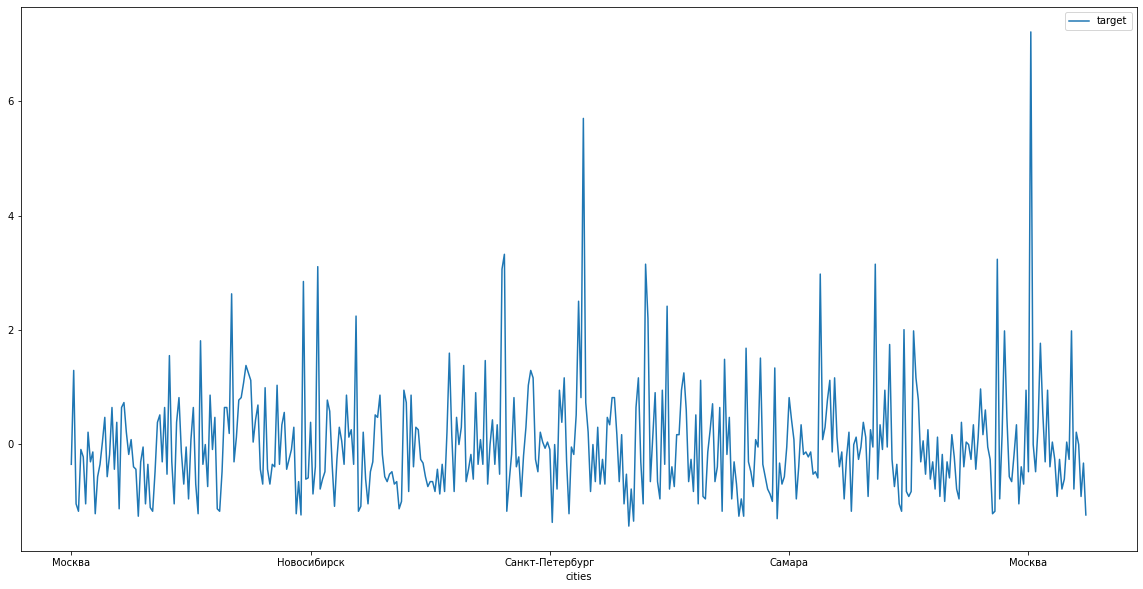

In [ ]:
train.plot('cities','target',
           figsize=(20, 10),
           legend=True);

## Из графика видно, что в Москве таргет больше у тех точек, где рядом банк

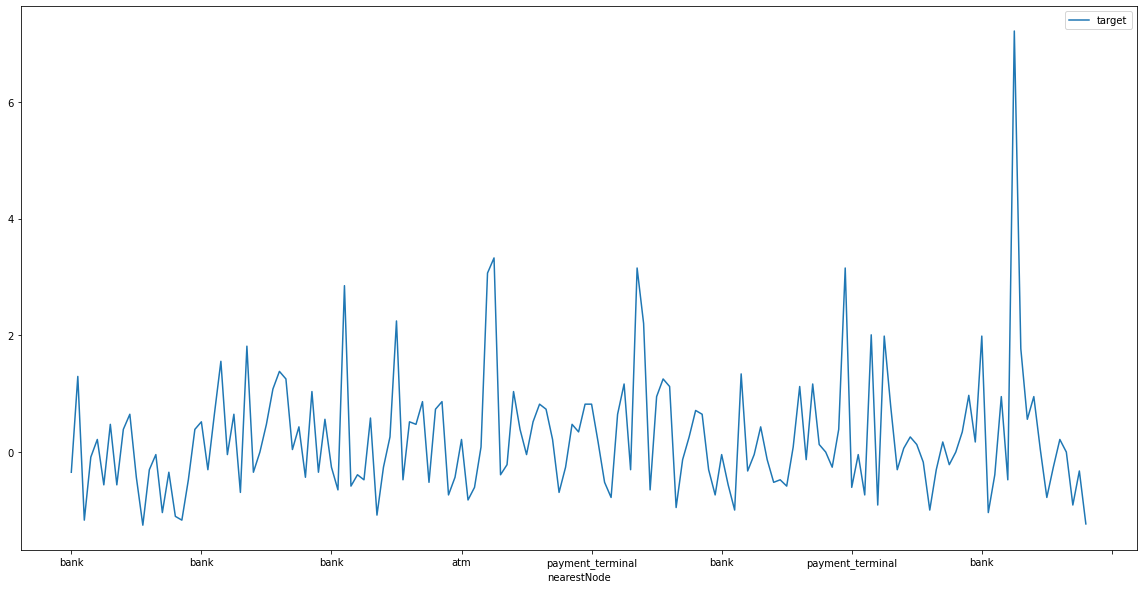

In [ ]:
train[train["cities"]=="Москва"].plot('nearestNode','target',
           figsize=(20, 10),
           legend=True);

## Из графика видно, что в СПБ больше таргет у точек, где рядом банкомат

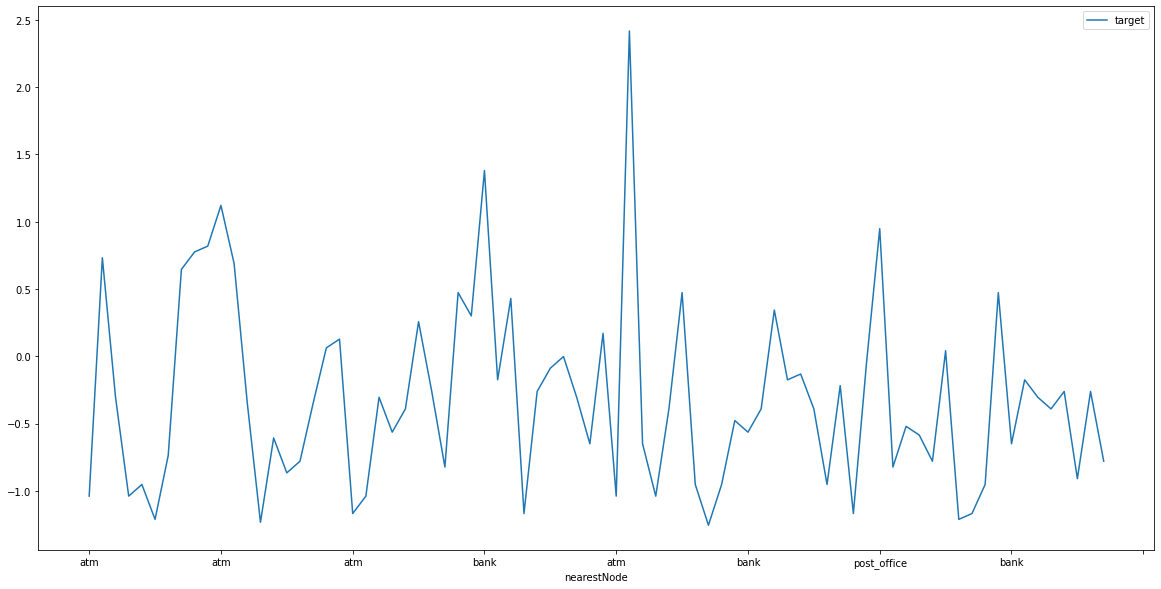

In [ ]:
train[train["cities"]=="Санкт-Петербург"].plot('nearestNode','target',
           figsize=(20, 10),
           legend=True);

In [ ]:
!pip install folium
import folium
from folium.plugins import HeatMap


## это плотность наших салонов

In [ ]:

m = folium.Map(location=[55.848630, 37.590776], 
               zoom_start=11, 
               tiles='cartodbpositron')

heat_data = [[row['lat'],row['lon']] for index, row in train.iterrows()]


HeatMap(heat_data,
        radius=25).add_to(m)
m

## так как слова компьютеру ничего не дают, переведем их на понятный ему язык)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train["cities"])
train["cities"] = le.transform(train["cities"])
le.fit(train["nearestNode"])
train["nearestNode"] = le.transform(train["nearestNode"])

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(test["cities"])
test["cities"] = le.transform(test["cities"])
le.fit(test["nearestNode"])
test["nearestNode"] = le.transform(test["nearestNode"])

In [ ]:
train

,point_id,lon,lat,target,cities,nearestNode
0,ommNZCUV,37.590776,55.848630,-0.348157,6,1
1,nMe2LHPb,37.784210,55.750271,1.294206,6,1
2,ZgodVRqB,39.635721,47.213330,-1.039679,10,4
3,0t2jNYdz,37.704570,55.782020,-1.169339,6,0
4,U27W4QJ7,37.643983,55.730188,-0.088837,6,0
...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,6,1
421,uNw6t6xk,37.586825,55.794233,-0.002397,6,0
422,Ap42ei8k,37.678790,55.772910,-0.910019,6,0
423,rn9A8r62,37.752130,55.619640,-0.326547,6,0


In [ ]:
test

,point_id,lon,lat,target,cities,nearestNode
0,F4lXR1cG,37.681242,55.748040,0.0091,4,0
1,4LJu4GTf,60.580910,56.795860,0.0091,0,0
2,kLuAAN3s,37.598614,55.781357,0.0091,4,1
3,OxQHvaNu,37.794051,55.717468,0.0091,4,0
4,paQsTa1K,49.213026,55.748290,0.0091,2,1
...,...,...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.0091,9,0
103,4nmfqUw0,92.928927,56.116262,0.0091,3,3
104,N9O45mAh,93.015993,56.023697,0.0091,3,4
105,h2InCLKa,30.381172,59.871149,0.0091,9,1


### Fit model

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [ ]:
mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.6088541163795984

### Make submission

In [ ]:
submission = pd.read_csv('./drive/MyDrive/data/sample_submission.csv')
submission['target'] = model.predict(X_valid.drop('point_id', axis=1))
submission.to_csv('sample_data/my_submission_01f.csv', index=False)